In [2]:
import matplotlib.pyplot as plt
import numpy as np

<Figure size 432x288 with 0 Axes>

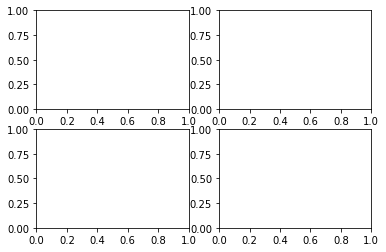

In [3]:
fig = plt.figure()
fig.suptitle('No axes on this figure')
fig, ax_lst = plt.subplots(2,2) # figure with 2x2 grid of axes

In [4]:
# up, down ramp - DS p.38
#tmax = 53e6  # wrong.  see total_time below
# Sampling clock is input clock - 28MHz. 
# Each half-cycle of fs a sample (14 bits) comes out. (Table 14, p.64)
fs = 28e6
ts = 1.0 / fs 
t_pos_step_f = fs / (2**(7 - 4))
t_neg_step_f = fs / (2**(7 - 7))
print(fs / 8)
print(fs)

3500000.0
28000000.0


In [5]:
start_gain = 6 + 80*0.125  # 16dB
# stop gain is the top of the ramp.  Must be larger than start gain.
# Gain N must be 0 to 319.  A value outside this range automatically goes to 0.
stop_gain = 6 + 220*0.125  # 33.5dB

In [6]:
# Time for entire image frame:
total_time = (1.0 / fs) * 2048
print(total_time)

7.314285714285714e-05


In [7]:
ramp_up_time = (33.5 - 16) / 0.125 / t_pos_step_f
print(ramp_up_time)

4e-05


In [8]:
ramp_down_time = (33.5 - 16) / 0.125 / t_neg_step_f
print(ramp_down_time)

5e-06


In [9]:
# fs period is 35.7ns
1/28.0

0.03571428571428571

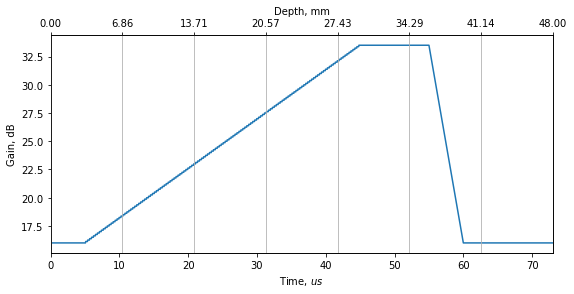

In [10]:
t = np.arange(0, total_time, total_time / 2048)
gain = []
gainv = start_gain
cnt = 0
for tn in t:
    cnt += 1
    if tn < 5e-6:
        gainv = start_gain
        gain.append(gainv)
    elif tn < 50e-6 and gainv < stop_gain and cnt % 8 == 0:
        gainv += 0.125
        gain.append(gainv)
    elif tn > 55e-6 and gainv > start_gain:
        gainv -= 0.125
        gain.append(gainv)
    else:
        gain.append(gainv)
        

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(t*10e5, gain)

depth = t[0::256] * 1500 / 2 * 1000
ax2 = ax1.twiny()
ax2.set_xticks(depth)
ax1.set_xlim(0.0, 73.0)
ax2.set_xlabel('Depth, mm')

ax1.set_xlabel(r'Time, $us$')
ax1.set_ylabel('Gain, dB')

#ax2.set_title("TGC Gain Curve")

plt.grid()
plt.show()
        

### Note: The AFE low-noise amplifiers are enabled by TR_EN signals controlled by max state machine. 
These signals need to be delayed to filter out the initial junk in input data.  Real data starts around 5us - 6us time.
Current delay is less than 1us.  
### Noise at the bottom of screen
Our pictures currently have a lot of noise right at the bottom of the screen.  This comes from the TR_EN switches 
turning off at 53us time mark.  This is controlled by a parameter in max state machine as well - VCNTLM and VCNTLP.
These parameters need to be extended to delay the switch to at least 70us.  
The ramp down of TGC will need to be delayed accordingly.

In [11]:
clock_period = 1/(112 * 10e6)
delay_total = (5040 + 45 + 24 + 112 + 224) * clock_period
delay_total

4.861607142857143e-06

In [12]:
delay = 224 * clock_period
delay

2e-07

### This is the actual delay before AFEs start reading input data - 0.8us!

TGC maximum gain is 45db.  Currently it only goes to 35db.  Need to fix it in the future.
The ramp seems to have the right gain, so both close shallow and deep features have similar values, but 
it could be adjusted to shift the whole curve up somewhat.
It is possible that the initial noise is not due to MUX switching, but rather due to AFE LNAs turning on (controlled by TR_EN signals).  In that case instead of delaying those signals further we will have to reduce the delay.  

### Custom TGC Profile based on depth - value pairs
The data sheet for AFEs does not talk about such a custom profile as Chris mentioned.  Use piece-wise-linear curve 

### Re-calculating  TGC Values to Maximize Gain
As indicated in the DS on page 39, there are six control parameters for Up/Down Ramp Mode, which in Profile 0 are set in registers 161 (hex A1) and 162 (hex A2):

| Name                   |Register| Bits | Calculation            | Default | Range    | Desired | Code |
|:----------------------:|--------|:----:|:----------------------:|:-------:|:--------:|:-------:|:----:|
|Start Gain              | 161    | 15:8 | 6 + N * 0.25 dB        |    0    | 0 to 159 | 20 dB   | 56   |
|Stop Gain               | 161    | 7:0  | 6 + N * 0.25 dB        |  159    | 0 to 159 | 45 dB   | 156  |
|Positive Step           | 162    | 15:11| (N + 1) * 0.125 dB     |    0    | 0 to 31  | 0.125dB |   0  |
|Positive Step Frequency | 162    | 10:8 | $\frac{fs}{2^{7 - N}}$ |    0    | 0 to 7   | 14 MHz  |   6  |
|Negative Step           | 162    | 7:3  | (N + 1) * 0.125 dB     |   31    | 0 to 31  | 0.5dB   |   3  |
|Negative Step Frequency | 162    | 2:0  | $\frac{fs}{2^{7 - N}}$ |    7    | 0 to 7   | 28 MHz  |   7  |

Total time is 7.314285714285714e-05, each sample is 3.571428571428571e-08
1.4285714285714285e-05
1.7857142857142857e-06


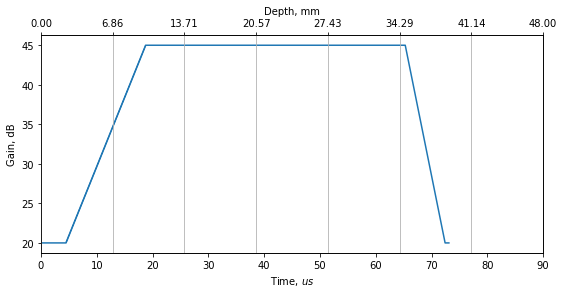

In [13]:
# Sampling clock is input clock - 28MHz. 
fs = 28e6
# fs period is 35.7ns
ts = 1.0 / fs 

start_gain_code = 56 # 20dB
stop_gain_code = 156 # 45dB
pos_step_code = 0    # 0.125 dB
pos_step_freq_code = 6  # 6 gives us fs/2 = 14 MHz.  This results in desired 1.8dB/us ramp. 5 gives 0.9 dB/us, a bit low.
neg_step_code = 3
neg_step_freq_code = 7

ramp_start_delay = 4.5e-6
ramp_down_delay = 65.3e-6

start_gain = 6 + start_gain_code * 0.25  
# stop gain is the top of the ramp.  Must be larger than start gain.
stop_gain = 6 + stop_gain_code * 0.25  
pos_step = (pos_step_code + 1) * 0.125
neg_step = (neg_step_code + 1) * 0.125

t_pos_step_f = fs / (2**(7 - pos_step_freq_code))
t_neg_step_f = fs / (2**(7 - neg_step_freq_code))
pos_divider = int(fs / t_pos_step_f)   # 8
neg_divider = int(fs / t_neg_step_f)   # 1

# Time for entire image frame:
total_time = (1.0 / fs) * 2048
print(f"Total time is {total_time}, each sample is {1.0 / fs}")

ramp_up_time = (stop_gain - start_gain) / pos_step / t_pos_step_f
print(ramp_up_time)

ramp_down_time = (stop_gain - start_gain) / neg_step / t_neg_step_f
print(ramp_down_time)

t = np.arange(0, total_time, total_time / 2048)
gain = []
gainv = start_gain
cnt = 0
for tn in t:
    cnt += 1
    if tn < ramp_start_delay:
        gainv = start_gain
        gain.append(gainv)
    elif tn < ramp_down_delay:
        if gainv < stop_gain and cnt % pos_divider == 0:
            gainv += 0.125
        gain.append(gainv)
    else:
        if gainv > start_gain and cnt % neg_divider == 0:
            gainv -= 0.125
        gain.append(gainv)

        

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(t*10e5, gain)

depth = t[0::256] * 1500 / 2 * 1000
ax2 = ax1.twiny()
ax2.set_xticks(depth)
ax1.set_xlim(0.0, 90.0)
ax2.set_xlabel('Depth, mm')

ax1.set_xlabel(r'Time, $us$')
ax1.set_ylabel('Gain, dB')

#ax2.set_title("TGC Gain Curve")

plt.grid()
plt.show()

There are several things that need to be changed to use up/down ramp:
* Write parameters into Profile 0 registers 161 & 162 (xA1, A2). Those are above parameters: start gain, stop gain, pos. step...
* Enable Up/Down ramp mode - write 01 into bits 15:14 in register 182 (xB6)
* Select Profile 0 - write 00 into bits 13:12  in register 182 (xB6)